In [1]:
import numpy as np
import pandas as pd
import refinitiv.dataplatform.eikon as ek
import option_ric_tools as ort
import datetime as dt
import py_vollib
ek.set_app_key('c6df6043eb754881a3811887844773e4c8de0815')


/Users/tommiflores/py312/lib/python3.12/site-packages/refinitiv/dataplatform/__init__.py:34: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
isin = 'US69608A1088'
maturity = '2025-11-21'
strikes = [195, 165]
kinds = ['C', 'P']

In [3]:
price_dfs = []
for kind in kinds:
    assert kind in ['C', 'P']
    for strike in strikes:
        kind_str = 'call' if kind == 'C' else 'P'
        print(f'\nFetching prices for {kind_str} option with strike price {strike}')
        rics, prices_list = ort.get_optionRic(isin, maturity, strike, kind)
        try:
            price_df = prices_list[0]
            price_df = price_df.drop(['BID', 'ASK'], axis=1)
            price_df.columns = [f'{kind}{strike}']
            price_dfs.append(price_df)
        except IndexError:
            print('Skipping empty combination')

price_df = pd.concat(price_dfs, axis=1)


Fetching prices for call option with strike price 195


/Users/tommiflores/RISK MANAGMENT PROJECT/option_ric_tools.py:326: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ricUnderlying = df['RIC'][0]


Option RIC for OPQ exchange is successfully constructed

Fetching prices for call option with strike price 165


/Users/tommiflores/RISK MANAGMENT PROJECT/option_ric_tools.py:326: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ricUnderlying = df['RIC'][0]


Option RIC for OPQ exchange is successfully constructed

Fetching prices for P option with strike price 195


/Users/tommiflores/RISK MANAGMENT PROJECT/option_ric_tools.py:326: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ricUnderlying = df['RIC'][0]


Option RIC for OPQ exchange is successfully constructed

Fetching prices for P option with strike price 165


/Users/tommiflores/RISK MANAGMENT PROJECT/option_ric_tools.py:326: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ricUnderlying = df['RIC'][0]


Option RIC for OPQ exchange is successfully constructed


In [4]:
ric = ek.get_symbology(symbol=isin, from_symbol_type='ISIN', to_symbol_type='RIC').iloc[0,0]
start_date_str = '2025-10-07'
end_date_str = '2025-11-21'
sdate = start_date_str
edate = end_date_str

stock = ek.get_timeseries(
    rics=[ric],
    fields=['CLOSE'],
    start_date=sdate,
    end_date=edate,
    interval='daily'
)

stock = stock.reset_index()
stock.columns.name = None
stock.index = stock['Date']
stock.index.name = None
stock = stock.drop('Date', axis=1)
stock.columns = ['Underlying']

price_df = stock.join(price_df)

In [5]:
col_to_keep = ['Underlying', 'C195', 'P165']
price_df = price_df[col_to_keep]

In [6]:
price_df.head()

,Underlying,C195,P165
2025-10-07,182.17,12.3,8.39
2025-10-08,183.56,11.85,7.75
2025-10-09,185.47,13.07,7.42
2025-10-10,175.44,9.3,11.08
2025-10-13,177.21,9.45,9.95


In [7]:
import matplotlib as plt
from scipy.stats import norm
from scipy.optimize import brentq

In [8]:
price_df['Date'] = price_df.index


In [9]:
#helper functions 
def bs_call_price(sigma, S, K, T, r):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def find_implied_volatility(market_price, S, K, T, r):
    if pd.isna(market_price) or T <= 0:
        return np.nan
        
    def objective_function(sigma):
        return bs_call_price(sigma, S, K, T, r) - market_price

    try:
        return brentq(objective_function, 1e-4, 5.0) 
    except (ValueError, RuntimeError):
        return np.nan

def calculate_delta(sigma, S, K, T, r):
    if pd.isna(sigma) or T <= 0:
        return np.nan
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def calculate_gamma(sigma, S, K, T, r): 
    if pd.isna(sigma) or T <= 0: 
        return np.nan
    d1 = (np.log(S/K ) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T)) 
    nd1 = norm.pdf(d1) 
    gamma = nd1 / (S*sigma*np.sqrt(T))
    return gamma

def shares_hedge(N_target, multiplier, delta): 
    return -(delta*(N_target*multiplier))

def bs_put_price(sigma, S, K, T, r):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    # Put Price Formula
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def find_put_iv(market_price, S, K, T, r):
    if pd.isna(market_price) or T <= 0:
        return np.nan
    def objective(sigma):
        return bs_put_price(sigma, S, K, T, r) - market_price
    try:
        return brentq(objective, 1e-4, 5.0)
    except (ValueError, RuntimeError):
        return np.nan

def calculate_put_delta(sigma, S, K, T, r):
    if pd.isna(sigma) or T <= 0:
        return np.nan
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    # Put Delta is N(d1) - 1
    return norm.cdf(d1) - 1.0

def calculate_vega(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T)
    return vega
    

In [10]:
#constants 
r = 0.0404
N_calls = 1
multiplier = 100
maturity_date = pd.to_datetime(maturity)

In [11]:
#new columns for delta hedging
price_df['T'] = np.nan
price_df['IV_195C'] = np.nan
price_df['Delta_195C'] = np.nan
price_df['Gamma_195C'] = np.nan
price_df['Vega_195C'] = np.nan

In [12]:
#sanity check 
price_df.head()

,Underlying,C195,P165,Date,T,IV_195C,Delta_195C,Gamma_195C,Vega_195C
2025-10-07,182.17,12.3,8.39,2025-10-07,NaN,NaN,NaN,NaN,NaN
2025-10-08,183.56,11.85,7.75,2025-10-08,NaN,NaN,NaN,NaN,NaN
2025-10-09,185.47,13.07,7.42,2025-10-09,NaN,NaN,NaN,NaN,NaN
2025-10-10,175.44,9.3,11.08,2025-10-10,NaN,NaN,NaN,NaN,NaN
2025-10-13,177.21,9.45,9.95,2025-10-13,NaN,NaN,NaN,NaN,NaN


In [13]:
# now we fill these columns: 
from py_vollib.black_scholes.greeks.analytical import vega
from py_vollib.black_scholes.greeks.analytical import delta
from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_vollib.black_scholes.greeks.analytical import gamma
for date, row in price_df.iterrows():
    current_date = pd.to_datetime(date)
    days_left = (maturity_date - current_date).days
    T = days_left / 365.0 

    if T > 0:
        S = row['Underlying']
        market_price = row['C195']
        K = 195
        r = 0.0404
        flag = 'c'
        iv_call = find_implied_volatility(market_price, S, 195, T, r)
        if not pd.isna(iv_call):
            gamma_call = gamma(flag, S, K, T, r, iv_call)
            delta_call = delta(flag, S, K, T, r, iv_call)
            vega_call = vega(flag, S, K, T, r, iv_call)
        else:
            gamma_call = np.nan
            delta_call = np.nan
            vega_call = np.nan
        
        price_df.at[date, 'T'] = T 
        price_df.at[date, 'IV_195C'] = iv_call
        price_df.at[date, 'Delta_195C'] = delta_call
        price_df.at[date, 'Gamma_195C'] = gamma_call
        price_df.at[date, 'Vega_195C'] = vega_call

    else:
       
        price_df.at[date, 'T'] = 0
        
        

,Underlying,C195,P165,Date,T,IV_195C,Delta_195C,Gamma_195C,Vega_195C
2025-10-07,182.17,12.3,8.39,2025-10-07,0.123288,0.669656,0.440105,0.009209,0.252299
2025-10-08,183.56,11.85,7.75,2025-10-08,0.120548,0.635063,0.443596,0.009758,0.251709
2025-10-09,185.47,13.07,7.42,2025-10-09,0.117808,0.656761,0.464758,0.009505,0.252972
2025-10-10,175.44,9.3,11.08,2025-10-10,0.115068,0.683052,0.374377,0.009323,0.225549
2025-10-13,177.21,9.45,9.95,2025-10-13,0.106849,0.685949,0.383887,0.009612,0.221233


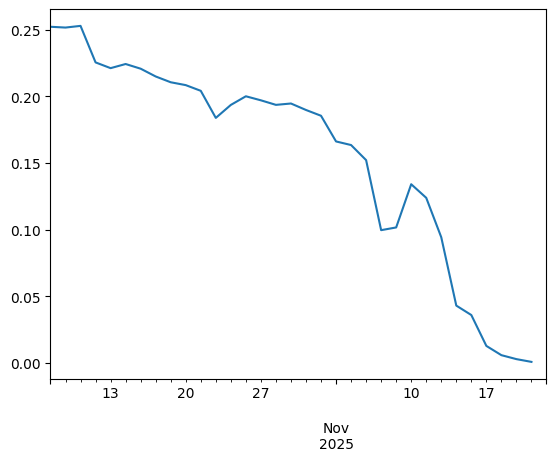

In [14]:
price_df['Vega_195C'].plot()
price_df.head()

In [15]:
# now we initialize the original portflio and the replicating portfolio as well as the number of stocks in our hedge 
price_df['Hedge_pos'] = np.nan
price_df['OP'] = np.nan
price_df['RE'] = np.nan


In [16]:
# now we fill these columns
def shares_hedge(N_target, multiplier, delta): 
    return -(delta*(N_target*multiplier))
    
for date, row in price_df.iterrows():
    delta = row['Delta_195C']
    if not np.isnan(delta):
        hedge = shares_hedge(N_calls, multiplier, delta) 
        price_df.at[date, 'Hedge_pos'] = hedge
    else:
        price_df.at[date, 'Hedge_pos'] = 0

    opt_value = row['C195']*N_calls*multiplier
    replicating = row['Hedge_pos']*row['Underlying']

    price_df.at[date, 'OP'] = opt_value 
    price_df.at[date, 'RE'] = replicating 

    curr_idx = price_df.index.get_loc(date)
    if curr_idx > 0:
        prev_date = price_df.index[curr_idx - 1]
        d_op = opt_value - price_df.at[prev_date, 'OP']
        prev_shares = price_df.at[prev_date, 'Hedge_pos']
        price_change = row['Underlying'] - price_df.at[prev_date, 'Underlying']
        d_hedge = prev_shares * price_change
        A = d_op + d_hedge
        price_df.at[date, 'dOP'] = d_op
        price_df.at[date, 'dRE'] = d_hedge 
        price_df.at[date, 'A'] = A

In [17]:
price_df.head()

,Underlying,C195,P165,Date,T,IV_195C,Delta_195C,Gamma_195C,Vega_195C,Hedge_pos,OP,RE,dOP,dRE,A
2025-10-07,182.17,12.3,8.39,2025-10-07,0.123288,0.669656,0.440105,0.009209,0.252299,-44.010535,1230.0,NaN,NaN,NaN,NaN
2025-10-08,183.56,11.85,7.75,2025-10-08,0.120548,0.635063,0.443596,0.009758,0.251709,-44.359580,1185.0,NaN,-45.0,-61.174644,-106.174644
2025-10-09,185.47,13.07,7.42,2025-10-09,0.117808,0.656761,0.464758,0.009505,0.252972,-46.475765,1307.0,NaN,122.0,-84.726798,37.273202
2025-10-10,175.44,9.3,11.08,2025-10-10,0.115068,0.683052,0.374377,0.009323,0.225549,-37.437694,930.0,NaN,-377.0,466.151918,89.151918
2025-10-13,177.21,9.45,9.95,2025-10-13,0.106849,0.685949,0.383887,0.009612,0.221233,-38.388747,945.0,NaN,15.0,-66.264719,-51.264719


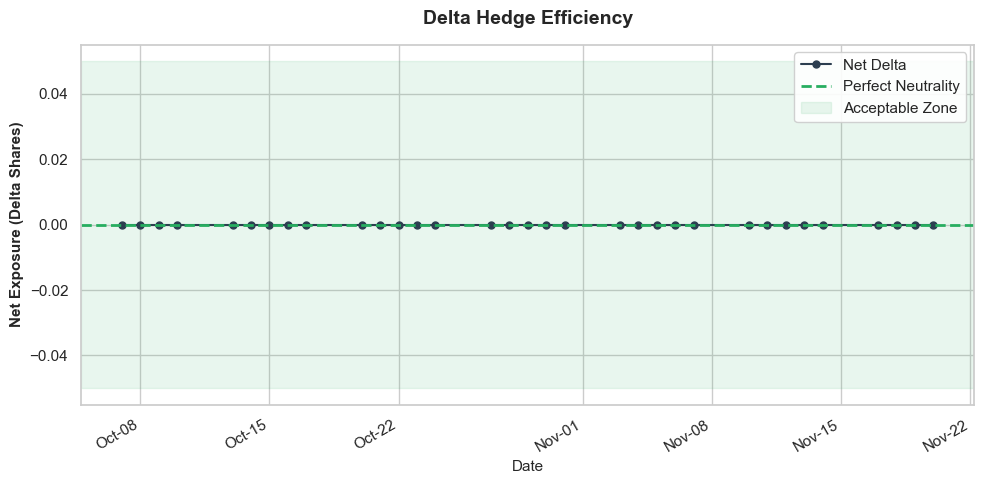

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from io import StringIO

MULTIPLIER = 100 
price_df['Net_Delta_Exposure'] = (price_df['Delta_195C'] * 100) + price_df['Hedge_pos']

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(price_df.index, price_df['Net_Delta_Exposure'], 
        color='#2c3e50',  
        marker='o',     
        markersize=5, 
        linewidth=1.5, 
        label='Net Delta')

ax.axhline(0, color='#27ae60', linewidth=2, linestyle='--', label='Perfect Neutrality')

limit = 0.05 
ax.axhspan(-limit, limit, color='#27ae60', alpha=0.1, label='Acceptable Zone')


ax.set_title('Delta Hedge Efficiency', fontsize=14, fontweight='bold', pad=15)
ax.set_ylabel('Net Exposure (Delta Shares)', fontsize=11, fontweight='bold')
ax.set_xlabel('Date', fontsize=11)


ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
fig.autofmt_xdate()


ax.legend(loc='upper right', frameon=True, framealpha=0.9, fancybox=True)

plt.tight_layout()
plt.show()


In [22]:
price_df['CumsumOP'] = price_df['dOP'].cumsum()
price_df['CumsumRE'] = price_df['dRE'].cumsum()
price_df['CumsumA'] = price_df['A'].cumsum()
import matplotlib.pyplot as plt

dx = price_df[['CumsumOP', 'CumsumRE', 'CumsumA']].plot(title='Cumulative gains/losses of all three portfolios', figsize=(10,6))

# Add markers for final values
for col in ['CumsumOP', 'CumsumRE', 'CumsumA']:
    last_val = price_df[col].iloc[-1]
    dx.plot(price_df.index[-1], last_val, 'o')  # 'o' makes a circle marker
    dx.text(price_df.index[-1], last_val, f'{last_val:.2f}', fontsize=12, va='bottom')

plt.show()

/var/folders/l0/8w4lhpkj14bfptbgnxd48mtm0000gn/T/ipykernel_15845/3757871273.py:11: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  dx.plot(price_df.index[-1], last_val, 'o')  # 'o' makes a circle marker


In [17]:
# replicating option 

isin = 'US69608A1088'
hedge_maturity = '2026-01-16'  
strike = 195
kind = 'C'



In [18]:
print(f'Fetching HEDGE {kind} option: Strike {strike}, Mat {hedge_maturity}')
_, hedge_list = ort.get_optionRic(isin, hedge_maturity, strike, kind)
hedge_df = hedge_list[0].drop(['BID', 'ASK'], axis=1)

# RENAME this column too
hedge_df.columns = ['Price_Hedge']

Fetching HEDGE C option: Strike 195, Mat 2026-01-16


/Users/tommiflores/RISK MANAGMENT PROJECT/option_ric_tools.py:326: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ricUnderlying = df['RIC'][0]


Option RIC for OPQ exchange is successfully constructed


In [19]:
full_df = pd.concat([price_df, hedge_df], axis=1, join='inner')


In [20]:
full_df.head()

,Underlying,C195,P165,Date,T,IV_195C,Delta_195C,Gamma_195C,Vega_195C,Hedge_pos,OP,RE,dOP,dRE,A,Price_Hedge
2025-10-07,182.17,12.3,8.39,2025-10-07,0.123288,0.669656,0.440105,0.009209,0.252299,-44.010535,1230.0,NaN,NaN,NaN,NaN,17.82
2025-10-08,183.56,11.85,7.75,2025-10-08,0.120548,0.635063,0.443596,0.009758,0.251709,-44.359580,1185.0,NaN,-45.0,-61.174644,-106.174644,18.18
2025-10-09,185.47,13.07,7.42,2025-10-09,0.117808,0.656761,0.464758,0.009505,0.252972,-46.475765,1307.0,NaN,122.0,-84.726798,37.273202,19.18
2025-10-10,175.44,9.3,11.08,2025-10-10,0.115068,0.683052,0.374377,0.009323,0.225549,-37.437694,930.0,NaN,-377.0,466.151918,89.151918,15.24
2025-10-13,177.21,9.45,9.95,2025-10-13,0.106849,0.685949,0.383887,0.009612,0.221233,-38.388747,945.0,NaN,15.0,-66.264719,-51.264719,15.05


In [21]:
#additional columns we will need which are : how many hedging options to sell, and how many shares to buy. 
# we are going to work on this specific dataframe as to not get it so crowded.
Delta_gamma_df = full_df[['Underlying', 'C195', 'T', 'Date', 'IV_195C', 'Delta_195C', 'Vega_195C', 'Price_Hedge']].copy()


In [22]:
Delta_gamma_df['T_hedge'] = np.nan
Delta_gamma_df['IV_Hedge'] = np.nan
Delta_gamma_df['Delta_Hedge'] = np.nan
Delta_gamma_df['Vega_Hedge'] = np.nan

In [23]:
# filling the necessary information about the hedge poisiton 
from py_vollib.black_scholes.greeks.analytical import vega
from py_vollib.black_scholes.greeks.analytical import delta
from py_vollib.black_scholes.implied_volatility import implied_volatility
hedge_maturity = pd.to_datetime('2026-01-16') # Convert once outside loop
Delta_gamma_df['Price_Hedge'] = pd.to_numeric(Delta_gamma_df['Price_Hedge'], errors = 'coerce') 

for date, row in Delta_gamma_df.iterrows(): 
    current_date = pd.to_datetime(date)
    days_left_hedge = (hedge_maturity - current_date).days
    T_hedge = days_left_hedge / 365.0
    
    if T_hedge > 0: 
        S = row['Underlying']
        hedge_price = row['Price_Hedge']
        r = 0.0404
        K = 195 
        
        if not pd.isna(hedge_price):
            iv_hedge = find_implied_volatility(hedge_price, S, K, T_hedge, r)
            if not pd.isna(iv_hedge):
                    delta_hedge = delta('c', S, K, T_hedge, r, iv_hedge)
                    vega_hedge = vega('c', S, K, T_hedge, r, iv_hedge) 

        Delta_gamma_df.at[date, 'T_hedge'] = T_hedge 
        Delta_gamma_df.at[date, 'IV_Hedge'] = iv_hedge 
        Delta_gamma_df.at[date, 'Delta_Hedge'] = delta_hedge 
        Delta_gamma_df.at[date, 'Vega_Hedge'] = vega_hedge # Now uses the correct variable        

In [24]:
Delta_gamma_df.head()

,Underlying,C195,T,Date,IV_195C,Delta_195C,Vega_195C,Price_Hedge,T_hedge,IV_Hedge,Delta_Hedge,Vega_Hedge
2025-10-07,182.17,12.3,0.123288,2025-10-07,0.669656,0.440105,0.252299,17.82,0.276712,0.580692,0.486647,0.382083
2025-10-08,183.56,11.85,0.120548,2025-10-08,0.635063,0.443596,0.251709,18.18,0.273973,0.575361,0.494646,0.383268
2025-10-09,185.47,13.07,0.117808,2025-10-09,0.656761,0.464758,0.252972,19.18,0.271233,0.579569,0.508465,0.385263
2025-10-10,175.44,9.3,0.115068,2025-10-10,0.683052,0.374377,0.225549,15.24,0.268493,0.604906,0.441998,0.358825
2025-10-13,177.21,9.45,0.106849,2025-10-13,0.685949,0.383887,0.221233,15.05,0.260274,0.587499,0.446611,0.357438


In [25]:
#now we add the new portfolios 
#alpha = amount of the underlying that we hold 
#eta = amount of the replicating optionss that we hold 

# Assuming you have your maturity dates defined as strings or datetime objects
target_maturity_date = pd.to_datetime('2025-11-21') 
hedge_maturity_date = pd.to_datetime('2026-01-16') # Or whatever your hedge date is


Delta_gamma_df['Alpha'] = np.nan
Delta_gamma_df['Eta'] = np.nan

for date, row in Delta_gamma_df.iterrows(): 
    # 1. FIX: Calculate Time for THIS specific row
    current_date = pd.to_datetime(date)
    
    # Calculate years remaining for Target (T) and Hedge (T_hedge)
    T = (target_maturity_date - current_date).days / 365.0
    T_hedge = (hedge_maturity_date - current_date).days / 365.0

    # 2. FIX: Check if options are still alive
    if T_hedge > 0 and T > 0: 
        
        # 3. Calculate Eta (Ratio)
        if row['Vega_Hedge'] != 0: 
            eta = row['Vega_195C'] / row['Vega_Hedge']
        else: 
            eta = 0 

        # 4. Calculate Alpha (Residual Delta)
        alpha = row['Delta_195C'] - (eta * row['Delta_Hedge']) 

        Delta_gamma_df.at[date, 'Alpha'] = alpha 
        Delta_gamma_df.at[date, 'Eta'] = eta
            


In [26]:
Delta_gamma_df.head()

,Underlying,C195,T,Date,IV_195C,Delta_195C,Vega_195C,Price_Hedge,T_hedge,IV_Hedge,Delta_Hedge,Vega_Hedge,Alpha,Eta
2025-10-07,182.17,12.3,0.123288,2025-10-07,0.669656,0.440105,0.252299,17.82,0.276712,0.580692,0.486647,0.382083,0.118760,0.660324
2025-10-08,183.56,11.85,0.120548,2025-10-08,0.635063,0.443596,0.251709,18.18,0.273973,0.575361,0.494646,0.383268,0.118740,0.656743
2025-10-09,185.47,13.07,0.117808,2025-10-09,0.656761,0.464758,0.252972,19.18,0.271233,0.579569,0.508465,0.385263,0.130889,0.656622
2025-10-10,175.44,9.3,0.115068,2025-10-10,0.683052,0.374377,0.225549,15.24,0.268493,0.604906,0.441998,0.358825,0.096547,0.628578
2025-10-13,177.21,9.45,0.106849,2025-10-13,0.685949,0.383887,0.221233,15.05,0.260274,0.587499,0.446611,0.357438,0.107462,0.618941


In [27]:
# now we make the portfolios!!!!
N_calls = 1 
multiplier = 100 


Delta_gamma_df['Value_OP'] = np.nan
Delta_gamma_df['Value_Replicating'] = np.nan 
Delta_gamma_df['Total_Portfolio'] = np.nan

for date, row in Delta_gamma_df.iterrows(): 
    alpha = row['Alpha']
    eta = row['Eta']
    call_price = row['C195']
    hedge_price = row['Price_Hedge']
    S = row['Underlying']

    trade_stock = -alpha*S
    trade_option = -eta*N_calls*hedge_price*multiplier

    valueOP = N_calls*multiplier*call_price 
    valueRE = trade_stock + trade_option
    totalP = valueOP + valueRE
    
    Delta_gamma_df.at[date, 'Value_OP'] = valueOP
    Delta_gamma_df.at[date, 'Value_Replicating'] = valueRE
    Delta_gamma_df.at[date, 'Total_Portfolio'] = totalP

    
    

    

In [28]:
Delta_gamma_df.head()

,Underlying,C195,T,Date,IV_195C,Delta_195C,Vega_195C,Price_Hedge,T_hedge,IV_Hedge,Delta_Hedge,Vega_Hedge,Alpha,Eta,Value_OP,Value_Replicating,Total_Portfolio
2025-10-07,182.17,12.3,0.123288,2025-10-07,0.669656,0.440105,0.252299,17.82,0.276712,0.580692,0.486647,0.382083,0.118760,0.660324,1230.0,-1198.332462,31.667538
2025-10-08,183.56,11.85,0.120548,2025-10-08,0.635063,0.443596,0.251709,18.18,0.273973,0.575361,0.494646,0.383268,0.118740,0.656743,1185.0,-1215.755098,-30.755098
2025-10-09,185.47,13.07,0.117808,2025-10-09,0.656761,0.464758,0.252972,19.18,0.271233,0.579569,0.508465,0.385263,0.130889,0.656622,1307.0,-1283.676789,23.323211
2025-10-10,175.44,9.3,0.115068,2025-10-10,0.683052,0.374377,0.225549,15.24,0.268493,0.604906,0.441998,0.358825,0.096547,0.628578,930.0,-974.891071,-44.891071
2025-10-13,177.21,9.45,0.106849,2025-10-13,0.685949,0.383887,0.221233,15.05,0.260274,0.587499,0.446611,0.357438,0.107462,0.618941,945.0,-950.548803,-5.548803


<Axes: >

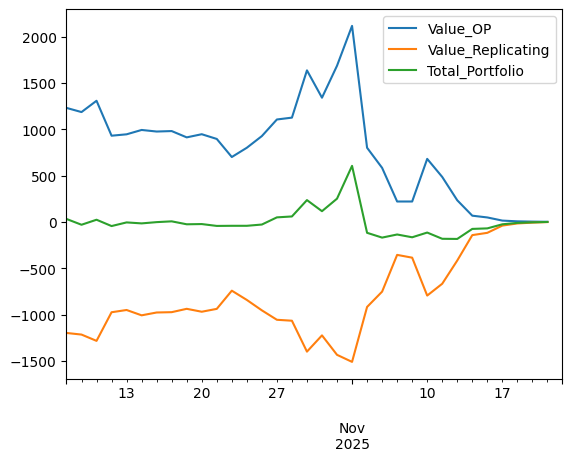

In [29]:
Delta_gamma_df[['Value_OP', 'Value_Replicating', 'Total_Portfolio']].plot()

In [30]:
Delta_gamma_df['Hedging_Error_DV'] = np.nan
for date, row in Delta_gamma_df.iterrows(): 
    replica = row['Value_Replicating'] 
    original = row['Value_OP'] 

    err = replica - original 
    Delta_gamma_df.at[date, 'Hedging_Error_DV'] = err 


    

In [31]:
Delta_gamma_df.head()

,Underlying,C195,T,Date,IV_195C,Delta_195C,Vega_195C,Price_Hedge,T_hedge,IV_Hedge,Delta_Hedge,Vega_Hedge,Alpha,Eta,Value_OP,Value_Replicating,Total_Portfolio,Hedging_Error_DV
2025-10-07,182.17,12.3,0.123288,2025-10-07,0.669656,0.440105,0.252299,17.82,0.276712,0.580692,0.486647,0.382083,0.118760,0.660324,1230.0,-1198.332462,31.667538,-2428.332462
2025-10-08,183.56,11.85,0.120548,2025-10-08,0.635063,0.443596,0.251709,18.18,0.273973,0.575361,0.494646,0.383268,0.118740,0.656743,1185.0,-1215.755098,-30.755098,-2400.755098
2025-10-09,185.47,13.07,0.117808,2025-10-09,0.656761,0.464758,0.252972,19.18,0.271233,0.579569,0.508465,0.385263,0.130889,0.656622,1307.0,-1283.676789,23.323211,-2590.676789
2025-10-10,175.44,9.3,0.115068,2025-10-10,0.683052,0.374377,0.225549,15.24,0.268493,0.604906,0.441998,0.358825,0.096547,0.628578,930.0,-974.891071,-44.891071,-1904.891071
2025-10-13,177.21,9.45,0.106849,2025-10-13,0.685949,0.383887,0.221233,15.05,0.260274,0.587499,0.446611,0.357438,0.107462,0.618941,945.0,-950.548803,-5.548803,-1895.548803


In [32]:
Delta_gamma_df.drop(['Hedging_Error_DV'], axis = 1)

,Underlying,C195,T,Date,IV_195C,Delta_195C,Vega_195C,Price_Hedge,T_hedge,IV_Hedge,Delta_Hedge,Vega_Hedge,Alpha,Eta,Value_OP,Value_Replicating,Total_Portfolio
2025-10-07,182.17,12.3,0.123288,2025-10-07,0.669656,0.440105,0.252299,17.82,0.276712,0.580692,0.486647,0.382083,0.118760,0.660324,1230.0,-1198.332462,31.667538
2025-10-08,183.56,11.85,0.120548,2025-10-08,0.635063,0.443596,0.251709,18.18,0.273973,0.575361,0.494646,0.383268,0.118740,0.656743,1185.0,-1215.755098,-30.755098
2025-10-09,185.47,13.07,0.117808,2025-10-09,0.656761,0.464758,0.252972,19.18,0.271233,0.579569,0.508465,0.385263,0.130889,0.656622,1307.0,-1283.676789,23.323211
2025-10-10,175.44,9.3,0.115068,2025-10-10,0.683052,0.374377,0.225549,15.24,0.268493,0.604906,0.441998,0.358825,0.096547,0.628578,930.0,-974.891071,-44.891071
2025-10-13,177.21,9.45,0.106849,2025-10-13,0.685949,0.383887,0.221233,15.05,0.260274,0.587499,0.446611,0.357438,0.107462,0.618941,945.0,-950.548803,-5.548803
2025-10-14,179.74,9.92,0.104110,2025-10-14,0.671556,0.401945,0.224342,15.95,0.257534,0.583822,0.463435,0.362362,0.115028,0.619110,992.0,-1008.155598,-16.155598
2025-10-15,179.62,9.75,0.101370,2025-10-15,0.675367,0.399164,0.220822,15.59,0.254795,0.578703,0.460191,0.359907,0.116812,0.613553,975.0,-977.510696,-2.510696
2025-10-16,178.12,9.8,0.098630,2025-10-16,0.714732,0.392279,0.214980,15.72,0.252055,0.604964,0.455126,0.354496,0.116272,0.606439,980.0,-974.032188,5.967812
2025-10-17,178.15,9.12,0.095890,2025-10-17,0.692454,0.383544,0.210637,15.35,0.249315,0.597599,0.452273,0.352328,0.113156,0.597842,912.0,-937.846318,-25.846318
2025-10-20,181.59,9.46,0.087671,2025-10-20,0.675579,0.405764,0.208489,16.1,0.241096,0.584416,0.471752,0.354819,0.128565,0.587593,946.0,-969.371618,-23.371618


In [33]:
results_df = pd.concat([price_df, Delta_gamma_df], axis=1, join='inner')

In [34]:
results_df.head()

,Underlying,C195,P165,Date,T,IV_195C,Delta_195C,Gamma_195C,Vega_195C,Hedge_pos,...,T_hedge,IV_Hedge,Delta_Hedge,Vega_Hedge,Alpha,Eta,Value_OP,Value_Replicating,Total_Portfolio,Hedging_Error_DV
2025-10-07,182.17,12.3,8.39,2025-10-07,0.123288,0.669656,0.440105,0.009209,0.252299,-44.010535,...,0.276712,0.580692,0.486647,0.382083,0.118760,0.660324,1230.0,-1198.332462,31.667538,-2428.332462
2025-10-08,183.56,11.85,7.75,2025-10-08,0.120548,0.635063,0.443596,0.009758,0.251709,-44.359580,...,0.273973,0.575361,0.494646,0.383268,0.118740,0.656743,1185.0,-1215.755098,-30.755098,-2400.755098
2025-10-09,185.47,13.07,7.42,2025-10-09,0.117808,0.656761,0.464758,0.009505,0.252972,-46.475765,...,0.271233,0.579569,0.508465,0.385263,0.130889,0.656622,1307.0,-1283.676789,23.323211,-2590.676789
2025-10-10,175.44,9.3,11.08,2025-10-10,0.115068,0.683052,0.374377,0.009323,0.225549,-37.437694,...,0.268493,0.604906,0.441998,0.358825,0.096547,0.628578,930.0,-974.891071,-44.891071,-1904.891071
2025-10-13,177.21,9.45,9.95,2025-10-13,0.106849,0.685949,0.383887,0.009612,0.221233,-38.388747,...,0.260274,0.587499,0.446611,0.357438,0.107462,0.618941,945.0,-950.548803,-5.548803,-1895.548803


In [35]:
price_df.head()

,Underlying,C195,P165,Date,T,IV_195C,Delta_195C,Gamma_195C,Vega_195C,Hedge_pos,OP,RE,dOP,dRE,A
2025-10-07,182.17,12.3,8.39,2025-10-07,0.123288,0.669656,0.440105,0.009209,0.252299,-44.010535,1230.0,NaN,NaN,NaN,NaN
2025-10-08,183.56,11.85,7.75,2025-10-08,0.120548,0.635063,0.443596,0.009758,0.251709,-44.359580,1185.0,NaN,-45.0,-61.174644,-106.174644
2025-10-09,185.47,13.07,7.42,2025-10-09,0.117808,0.656761,0.464758,0.009505,0.252972,-46.475765,1307.0,NaN,122.0,-84.726798,37.273202
2025-10-10,175.44,9.3,11.08,2025-10-10,0.115068,0.683052,0.374377,0.009323,0.225549,-37.437694,930.0,NaN,-377.0,466.151918,89.151918
2025-10-13,177.21,9.45,9.95,2025-10-13,0.106849,0.685949,0.383887,0.009612,0.221233,-38.388747,945.0,NaN,15.0,-66.264719,-51.264719


In [36]:

for date, row in price_df.iterrows(): 
    replicating = row['Underlying']*row['Hedge_pos'] 
    price_df.at[date, 'RE'] = replicating 

    
    

In [37]:
price_df.head()

,Underlying,C195,P165,Date,T,IV_195C,Delta_195C,Gamma_195C,Vega_195C,Hedge_pos,OP,RE,dOP,dRE,A
2025-10-07,182.17,12.3,8.39,2025-10-07,0.123288,0.669656,0.440105,0.009209,0.252299,-44.010535,1230.0,-8017.399221,NaN,NaN,NaN
2025-10-08,183.56,11.85,7.75,2025-10-08,0.120548,0.635063,0.443596,0.009758,0.251709,-44.359580,1185.0,-8142.644565,-45.0,-61.174644,-106.174644
2025-10-09,185.47,13.07,7.42,2025-10-09,0.117808,0.656761,0.464758,0.009505,0.252972,-46.475765,1307.0,-8619.860042,122.0,-84.726798,37.273202
2025-10-10,175.44,9.3,11.08,2025-10-10,0.115068,0.683052,0.374377,0.009323,0.225549,-37.437694,930.0,-6568.069086,-377.0,466.151918,89.151918
2025-10-13,177.21,9.45,9.95,2025-10-13,0.106849,0.685949,0.383887,0.009612,0.221233,-38.388747,945.0,-6802.869883,15.0,-66.264719,-51.264719


In [38]:
results_df.head()


,Underlying,C195,P165,Date,T,IV_195C,Delta_195C,Gamma_195C,Vega_195C,Hedge_pos,...,T_hedge,IV_Hedge,Delta_Hedge,Vega_Hedge,Alpha,Eta,Value_OP,Value_Replicating,Total_Portfolio,Hedging_Error_DV
2025-10-07,182.17,12.3,8.39,2025-10-07,0.123288,0.669656,0.440105,0.009209,0.252299,-44.010535,...,0.276712,0.580692,0.486647,0.382083,0.118760,0.660324,1230.0,-1198.332462,31.667538,-2428.332462
2025-10-08,183.56,11.85,7.75,2025-10-08,0.120548,0.635063,0.443596,0.009758,0.251709,-44.359580,...,0.273973,0.575361,0.494646,0.383268,0.118740,0.656743,1185.0,-1215.755098,-30.755098,-2400.755098
2025-10-09,185.47,13.07,7.42,2025-10-09,0.117808,0.656761,0.464758,0.009505,0.252972,-46.475765,...,0.271233,0.579569,0.508465,0.385263,0.130889,0.656622,1307.0,-1283.676789,23.323211,-2590.676789
2025-10-10,175.44,9.3,11.08,2025-10-10,0.115068,0.683052,0.374377,0.009323,0.225549,-37.437694,...,0.268493,0.604906,0.441998,0.358825,0.096547,0.628578,930.0,-974.891071,-44.891071,-1904.891071
2025-10-13,177.21,9.45,9.95,2025-10-13,0.106849,0.685949,0.383887,0.009612,0.221233,-38.388747,...,0.260274,0.587499,0.446611,0.357438,0.107462,0.618941,945.0,-950.548803,-5.548803,-1895.548803


In [39]:
results_df = pd.concat([price_df, Delta_gamma_df], axis=1, join='inner')

In [40]:
### now i want to calculate the changes in portfolio daily in the vega hegde portoflio 
Delta_gamma_df['dOP_daily'] = Delta_gamma_df['Value_OP'].diff()
Delta_gamma_df['dRE_daily'] = Delta_gamma_df['Value_Replicating'].diff()  # use signed values
Delta_gamma_df['dnl'] = Delta_gamma_df['dOP_daily'] + Delta_gamma_df['dRE_daily']

       

In [41]:
Delta_gamma_df.head()

,Underlying,C195,T,Date,IV_195C,Delta_195C,Vega_195C,Price_Hedge,T_hedge,IV_Hedge,...,Vega_Hedge,Alpha,Eta,Value_OP,Value_Replicating,Total_Portfolio,Hedging_Error_DV,dOP_daily,dRE_daily,dnl
2025-10-07,182.17,12.3,0.123288,2025-10-07,0.669656,0.440105,0.252299,17.82,0.276712,0.580692,...,0.382083,0.118760,0.660324,1230.0,-1198.332462,31.667538,-2428.332462,NaN,NaN,NaN
2025-10-08,183.56,11.85,0.120548,2025-10-08,0.635063,0.443596,0.251709,18.18,0.273973,0.575361,...,0.383268,0.118740,0.656743,1185.0,-1215.755098,-30.755098,-2400.755098,-45.0,-17.422636,-62.422636
2025-10-09,185.47,13.07,0.117808,2025-10-09,0.656761,0.464758,0.252972,19.18,0.271233,0.579569,...,0.385263,0.130889,0.656622,1307.0,-1283.676789,23.323211,-2590.676789,122.0,-67.921691,54.078309
2025-10-10,175.44,9.3,0.115068,2025-10-10,0.683052,0.374377,0.225549,15.24,0.268493,0.604906,...,0.358825,0.096547,0.628578,930.0,-974.891071,-44.891071,-1904.891071,-377.0,308.785718,-68.214282
2025-10-13,177.21,9.45,0.106849,2025-10-13,0.685949,0.383887,0.221233,15.05,0.260274,0.587499,...,0.357438,0.107462,0.618941,945.0,-950.548803,-5.548803,-1895.548803,15.0,24.342268,39.342268


In [42]:
results_df = pd.concat([price_df, Delta_gamma_df], axis=1, join='inner')

<Axes: >

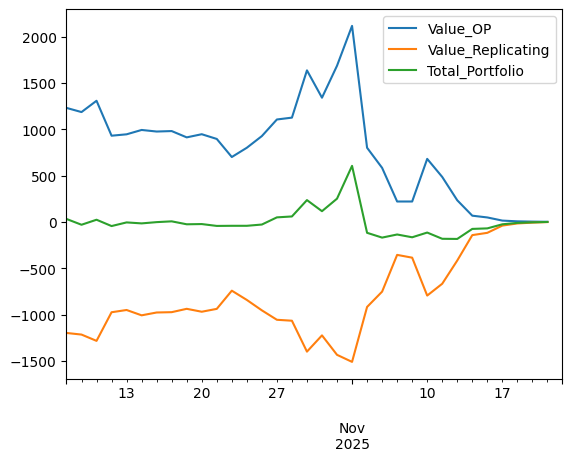

In [43]:
results_df[['Value_OP','Value_Replicating', 'Total_Portfolio']].plot()

Text(0, 0.5, 'Delta')

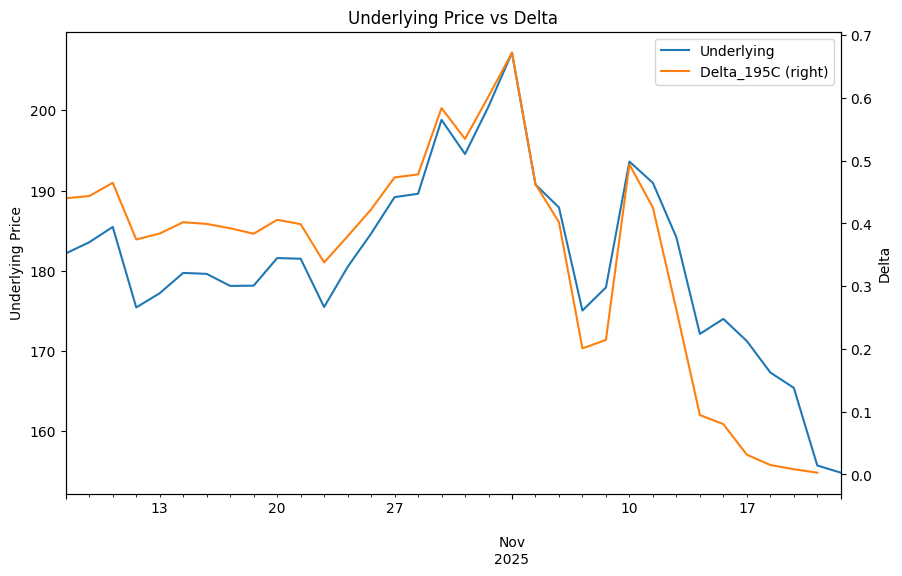

In [44]:
# add total portfoliofor both 
#Plot 1 Underlying versus volatiltiy over time
ax = price_df[['Underlying', 'Delta_195C']].plot(
    secondary_y = ['Delta_195C'], figsize = (10,6), title = 'Underlying Price vs Delta') 
ax.set_ylabel('Underlying Price')
ax.right_ax.set_ylabel('Delta')


In [45]:
#plot 2
#first we need to add total portfolio of price_Df since we only have OP and RE and A, i think it would be valuable to have both 
price_df['TotalP'] = np.nan
price_df['IV_change'] = price_df['IV_195C'].diff()
for date, row in price_df.iterrows(): 
    price_df.at[date, 'TotalP'] = row['OP'] + row['RE']

price_df.head()




,Underlying,C195,P165,Date,T,IV_195C,Delta_195C,Gamma_195C,Vega_195C,Hedge_pos,OP,RE,dOP,dRE,A,TotalP,IV_change
2025-10-07,182.17,12.3,8.39,2025-10-07,0.123288,0.669656,0.440105,0.009209,0.252299,-44.010535,1230.0,-8017.399221,NaN,NaN,NaN,-6787.399221,NaN
2025-10-08,183.56,11.85,7.75,2025-10-08,0.120548,0.635063,0.443596,0.009758,0.251709,-44.359580,1185.0,-8142.644565,-45.0,-61.174644,-106.174644,-6957.644565,-0.034593
2025-10-09,185.47,13.07,7.42,2025-10-09,0.117808,0.656761,0.464758,0.009505,0.252972,-46.475765,1307.0,-8619.860042,122.0,-84.726798,37.273202,-7312.860042,0.021697
2025-10-10,175.44,9.3,11.08,2025-10-10,0.115068,0.683052,0.374377,0.009323,0.225549,-37.437694,930.0,-6568.069086,-377.0,466.151918,89.151918,-5638.069086,0.026291
2025-10-13,177.21,9.45,9.95,2025-10-13,0.106849,0.685949,0.383887,0.009612,0.221233,-38.388747,945.0,-6802.869883,15.0,-66.264719,-51.264719,-5857.869883,0.002897


Text(878.0555555555555, 0.5, 'dRE')

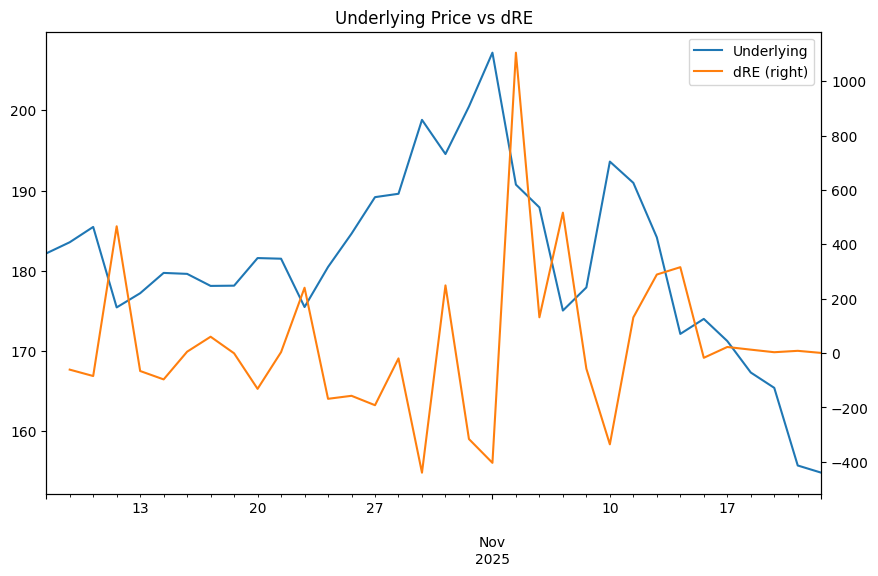

In [46]:
bx = price_df[['Underlying', 'dRE']].plot(
    secondary_y = ['dRE'], figsize = (10,6), title = 'Underlying Price vs dRE') 
ax.set_ylabel('Underlying Price')
ax.right_ax.set_ylabel('dRE')

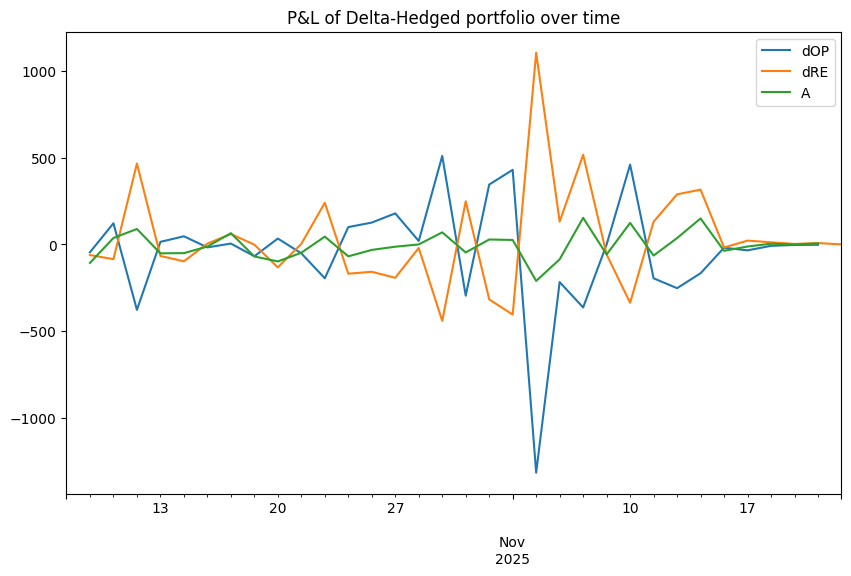

In [47]:
cx = price_df[['dOP', 'dRE', 'A']].plot(
    figsize = (10,6), title = "P&L of Delta-Hedged portfolio over time"
)

In [48]:
fig, ax1 = plt.subplots(figsize=(12, 7))

# 1. The Background Layer (Stock Price on Secondary Axis)
ax2 = ax1.twinx()  # Create a twin axis sharing the x-axis
ax2.plot(price_df.index, price_df['Underlying'], 
         color='gray', 
         alpha=0.15,       # Very faint
         linewidth=4,      # Thick but faint looks modern
         linestyle='-',
         label='Underlying Price (Right Axis)')
ax2.set_ylabel('Stock Price ($)', color='gray', fontsize=10)
ax2.tick_params(axis='y', labelcolor='gray')
ax2.grid(False) # Turn off grid for the secondary axis to avoid clutter

# 2. The Components (OP and RE)
# We make these thinner and slightly transparent so they don't dominate
ax1.plot(price_df.index, price_df['dOP'], label='Original Portfolio (Option)', 
         color='red', alpha=0.6, linestyle='--', linewidth=1)
ax1.plot(price_df.index, price_df['dRE'], label='Replicating Portfolio (Hedge)', 
         color='green', alpha=0.6, linestyle='--', linewidth=1)

# 3. The "Star" (Total PnL)
ax1.plot(price_df.index, price_df['A'], label='Total Net PnL', 
         color='black', linewidth=1.5)

# 4. The "Excellence" Factor (Conditional Shading)
# Fill green where PnL > 0, Red where PnL < 0
ax1.fill_between(price_df.index, price_df['A'], 0, 
                 where=(price_df['A'] >= 0), 
                 interpolate=True, color='green', alpha=0.1)
ax1.fill_between(price_df.index, price_df['A'], 0, 
                 where=(price_df['A'] <= 0), 
                 interpolate=True, color='red', alpha=0.1)

# 5. Formatting
ax1.set_title('Daily Hedging Performance vs Market Movement', fontsize=14, pad=15)
ax1.set_ylabel('Daily PnL ($)', fontsize=12)
ax1.axhline(0, color='black', linewidth=0.8) # Strong zero line
ax1.grid(True, linestyle=':', alpha=0.6)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()

AttributeError: module 'matplotlib' has no attribute 'subplots'

In [49]:
price_df

,Underlying,C195,P165,Date,T,IV_195C,Delta_195C,Gamma_195C,Vega_195C,Hedge_pos,OP,RE,dOP,dRE,A,TotalP,IV_change
2025-10-07,182.17,12.3,8.39,2025-10-07,0.123288,0.669656,0.440105,0.009209,0.252299,-44.010535,1230.0,-8017.399221,NaN,NaN,NaN,-6787.399221,NaN
2025-10-08,183.56,11.85,7.75,2025-10-08,0.120548,0.635063,0.443596,0.009758,0.251709,-44.359580,1185.0,-8142.644565,-45.0,-61.174644,-106.174644,-6957.644565,-0.034593
2025-10-09,185.47,13.07,7.42,2025-10-09,0.117808,0.656761,0.464758,0.009505,0.252972,-46.475765,1307.0,-8619.860042,122.0,-84.726798,37.273202,-7312.860042,0.021697
2025-10-10,175.44,9.3,11.08,2025-10-10,0.115068,0.683052,0.374377,0.009323,0.225549,-37.437694,930.0,-6568.069086,-377.0,466.151918,89.151918,-5638.069086,0.026291
2025-10-13,177.21,9.45,9.95,2025-10-13,0.106849,0.685949,0.383887,0.009612,0.221233,-38.388747,945.0,-6802.869883,15.0,-66.264719,-51.264719,-5857.869883,0.002897
2025-10-14,179.74,9.92,8.77,2025-10-14,0.104110,0.671556,0.401945,0.009932,0.224342,-40.194522,992.0,-7224.563338,47.0,-97.123530,-50.123530,-6232.563338,-0.014393
2025-10-15,179.62,9.75,9.1,2025-10-15,0.101370,0.675367,0.399164,0.009997,0.220822,-39.916364,975.0,-7169.777328,-17.0,4.823343,-12.176657,-6194.777328,0.003811
2025-10-16,178.12,9.8,9.7,2025-10-16,0.098630,0.714732,0.392279,0.009612,0.214980,-39.227881,980.0,-6987.270202,5.0,59.874546,64.874546,-6007.270202,0.039365
2025-10-17,178.15,9.12,9.2,2025-10-17,0.095890,0.692454,0.383544,0.009995,0.210637,-38.354369,912.0,-6832.830810,-68.0,-1.176836,-69.176836,-5920.830810,-0.022278
2025-10-20,181.59,9.46,7.32,2025-10-20,0.087671,0.675579,0.405764,0.010675,0.208489,-40.576377,946.0,-7368.264251,34.0,-131.939029,-97.939029,-6422.264251,-0.016875


In [50]:
fig, ax1 = plt.subplots(figsize=(12, 7))

# 1. The Background Layer (Stock Price on Secondary Axis)
ax2 = ax1.twinx()  # Create a twin axis sharing the x-axis
ax2.plot(Delta_gamma_df.index, Delta_gamma_df['Underlying'], 
         color='gray', 
         alpha=0.15,       # Very faint
         linewidth=4,      # Thick but faint looks modern
         linestyle='-',
         label='Underlying Price (Right Axis)')
ax2.set_ylabel('Stock Price ($)', color='gray', fontsize=10)
ax2.tick_params(axis='y', labelcolor='gray')
ax2.grid(False) # Turn off grid for the secondary axis to avoid clutter

# 2. The Components (OP and RE)
# We make these thinner and slightly transparent so they don't dominate
ax1.plot(Delta_gamma_df.index, Delta_gamma_df['dOP_daily'], label='Original Portfolio (Option)', 
         color='red', alpha=0.6, linestyle='--', linewidth=1)
ax1.plot(Delta_gamma_df.index, Delta_gamma_df['dRE_daily'], label='Replicating Portfolio (Hedge)', 
         color='green', alpha=0.6, linestyle='--', linewidth=1)

# 3. The "Star" (Total PnL)
ax1.plot(Delta_gamma_df.index, Delta_gamma_df['dnl'], label='Total Net PnL', 
         color='black', linewidth=1.5)

# 4. The "Excellence" Factor (Conditional Shading)
# Fill green where PnL > 0, Red where PnL < 0
ax1.fill_between(Delta_gamma_df.index, Delta_gamma_df['dnl'], 0, 
                 where=(Delta_gamma_df['dnl'] >= 0), 
                 interpolate=True, color='green', alpha=0.1)
ax1.fill_between(Delta_gamma_df.index, Delta_gamma_df['dnl'], 0, 
                 where=(Delta_gamma_df['dnl'] <= 0), 
                 interpolate=True, color='red', alpha=0.1)

# 5. Formatting
ax1.set_title('Daily Hedging Performance vs Market Movement', fontsize=14, pad=15)
ax1.set_ylabel('Daily PnL ($)', fontsize=12)
ax1.axhline(0, color='black', linewidth=0.8) # Strong zero line
ax1.grid(True, linestyle=':', alpha=0.6)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()

AttributeError: module 'matplotlib' has no attribute 'subplots'

In [51]:
A = price_df['A'].dropna()
n = len(A) 
E = (A**2).sum() / (n - 1)
print("Mean Squared Hedging Error:", E)

Mean Squared Hedging Error: 6009.408362363091


In [52]:
A2 = Delta_gamma_df['dnl'].dropna()
n = len(A2) 
E2 = (A2**2).sum() / (n - 1)
print("Mean Squared Hedging Error:", E2)

Mean Squared Hedging Error: 24441.634139357302


In [53]:
price_df['CumsumA'] = price_df['A'].cumsum()

In [54]:
price_df.tail()

,Underlying,C195,P165,Date,T,IV_195C,Delta_195C,Gamma_195C,Vega_195C,Hedge_pos,OP,RE,dOP,dRE,A,TotalP,IV_change,CumsumA
2025-11-17,171.25,0.14,2.5,2025-11-17,0.010959,0.652704,0.031435,0.006044,0.012679,-3.143501,14.0,-538.324546,-34.0,22.107028,-11.892972,-524.324546,0.086905,-235.975309
2025-11-18,167.33,0.06,3.74,2025-11-18,0.008219,0.763461,0.014945,0.003259,0.005727,-1.494480,6.0,-250.071304,-8.0,12.322524,4.322524,-244.071304,0.110757,-231.652785
2025-11-19,165.42,0.03,3.95,2025-11-19,0.005479,0.912810,0.008250,0.002015,0.002758,-0.825020,3.0,-136.474833,-3.0,2.854456,-0.145544,-133.474833,0.149349,-231.798328
2025-11-20,155.745,0.01,9.51,2025-11-20,0.002740,1.523960,0.002746,0.000680,0.000689,-0.274607,1.0,-42.768646,-2.0,7.982070,5.982070,-41.768646,0.611149,-225.816258
2025-11-21,154.85,<NA>,<NA>,2025-11-21,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,0.245773,NaN,NaN,NaN,NaN


In [55]:
Delta_gamma_df['CumSumDnl'] = Delta_gamma_df['dnl'].cumsum()

In [56]:
Delta_gamma_df.tail()

,Underlying,C195,T,Date,IV_195C,Delta_195C,Vega_195C,Price_Hedge,T_hedge,IV_Hedge,...,Alpha,Eta,Value_OP,Value_Replicating,Total_Portfolio,Hedging_Error_DV,dOP_daily,dRE_daily,dnl,CumSumDnl
2025-11-17,171.25,0.14,0.010959,2025-11-17,0.652704,0.031435,0.012679,7.4,0.164384,0.551218,...,0.014792,0.050420,14.0,-39.843713,-25.843713,-53.843713,-34.0,78.153629,44.153629,-57.511251
2025-11-18,167.33,0.06,0.008219,2025-11-18,0.763461,0.014945,0.005727,6.3,0.161644,0.561326,...,0.007655,0.024638,6.0,-16.802904,-10.802904,-22.802904,-8.0,23.040809,15.040809,-42.470442
2025-11-19,165.42,0.03,0.005479,2025-11-19,0.912810,0.008250,0.002758,5.59,0.158904,0.559029,...,0.004804,0.012535,3.0,-7.801848,-4.801848,-10.801848,-3.0,9.001056,6.001056,-36.469386
2025-11-20,155.745,0.01,0.002740,2025-11-20,1.523960,0.002746,0.000689,3.62,0.156164,0.580631,...,0.001945,0.003983,1.0,-1.744627,-0.744627,-2.744627,-2.0,6.057221,4.057221,-32.412165
2025-11-21,154.85,<NA>,0.000000,2025-11-21,NaN,NaN,NaN,3.49,0.153425,0.588776,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: title={'center': 'Cumulative gains/losses of all three portfolios'}>

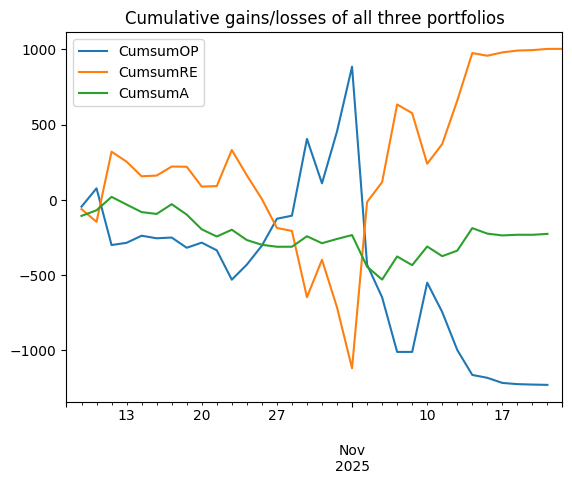

In [57]:
price_df['CumsumOP'] = price_df['dOP'].cumsum()
price_df['CumsumRE'] = price_df['dRE'].cumsum()
price_df[['CumsumOP', 'CumsumRE', 'CumsumA']].plot(title = 'Cumulative gains/losses of all three portfolios')

Text(0, 0.5, 'Greeks(Delta and Vega)')

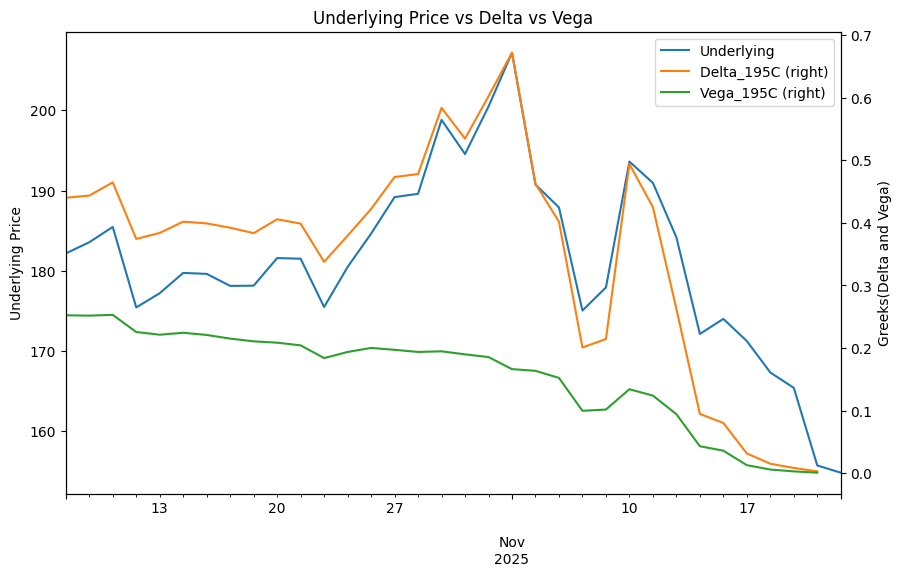

In [58]:

rx = Delta_gamma_df[['Underlying', 'Delta_195C', 'Vega_195C']].plot(
    secondary_y = ['Delta_195C', 'Vega_195C'], figsize = (10,6), title = 'Underlying Price vs Delta vs Vega') 
rx.set_ylabel('Underlying Price')
rx.right_ax.set_ylabel('Greeks(Delta and Vega)')


In [67]:
Delta_gamma_df.head()

,Underlying,C195,T,Date,IV_195C,Delta_195C,Vega_195C,Price_Hedge,T_hedge,IV_Hedge,...,Alpha,Eta,Value_OP,Value_Replicating,Total_Portfolio,Hedging_Error_DV,dOP_daily,dRE_daily,dnl,CumSumDnl
2025-10-07,182.17,12.3,0.123288,2025-10-07,0.669656,0.440105,0.252299,17.82,0.276712,0.580692,...,0.118760,0.660324,1230.0,-1198.332462,31.667538,-2428.332462,NaN,NaN,NaN,NaN
2025-10-08,183.56,11.85,0.120548,2025-10-08,0.635063,0.443596,0.251709,18.18,0.273973,0.575361,...,0.118740,0.656743,1185.0,-1215.755098,-30.755098,-2400.755098,-45.0,-17.422636,-62.422636,-62.422636
2025-10-09,185.47,13.07,0.117808,2025-10-09,0.656761,0.464758,0.252972,19.18,0.271233,0.579569,...,0.130889,0.656622,1307.0,-1283.676789,23.323211,-2590.676789,122.0,-67.921691,54.078309,-8.344326
2025-10-10,175.44,9.3,0.115068,2025-10-10,0.683052,0.374377,0.225549,15.24,0.268493,0.604906,...,0.096547,0.628578,930.0,-974.891071,-44.891071,-1904.891071,-377.0,308.785718,-68.214282,-76.558609
2025-10-13,177.21,9.45,0.106849,2025-10-13,0.685949,0.383887,0.221233,15.05,0.260274,0.587499,...,0.107462,0.618941,945.0,-950.548803,-5.548803,-1895.548803,15.0,24.342268,39.342268,-37.216341


<Axes: title={'center': 'Cummulative gains/losses of all three portfolios'}>

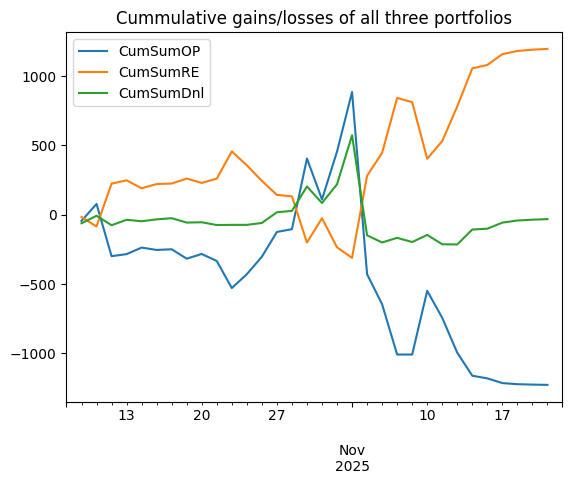

In [69]:
Delta_gamma_df['CumSumOP'] = Delta_gamma_df['dOP_daily'].cumsum()
Delta_gamma_df['CumSumRE'] = Delta_gamma_df['dRE_daily'].cumsum()

Delta_gamma_df[['CumSumOP','CumSumRE','CumSumDnl']].plot(title ='Cummulative gains/losses of all three portfolios')

In [59]:
price_df.tail()

,Underlying,C195,P165,Date,T,IV_195C,Delta_195C,Gamma_195C,Vega_195C,Hedge_pos,OP,RE,dOP,dRE,A,TotalP,IV_change,CumsumA,CumsumOP,CumsumRE
2025-11-17,171.25,0.14,2.5,2025-11-17,0.010959,0.652704,0.031435,0.006044,0.012679,-3.143501,14.0,-538.324546,-34.0,22.107028,-11.892972,-524.324546,0.086905,-235.975309,-1216.0,980.024691
2025-11-18,167.33,0.06,3.74,2025-11-18,0.008219,0.763461,0.014945,0.003259,0.005727,-1.494480,6.0,-250.071304,-8.0,12.322524,4.322524,-244.071304,0.110757,-231.652785,-1224.0,992.347215
2025-11-19,165.42,0.03,3.95,2025-11-19,0.005479,0.912810,0.008250,0.002015,0.002758,-0.825020,3.0,-136.474833,-3.0,2.854456,-0.145544,-133.474833,0.149349,-231.798328,-1227.0,995.201672
2025-11-20,155.745,0.01,9.51,2025-11-20,0.002740,1.523960,0.002746,0.000680,0.000689,-0.274607,1.0,-42.768646,-2.0,7.982070,5.982070,-41.768646,0.611149,-225.816258,-1229.0,1003.183742
2025-11-21,154.85,<NA>,<NA>,2025-11-21,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,0.245773,NaN,NaN,NaN,NaN,NaN,1003.429515


<Axes: title={'center': 'Alpha and Eta of Hedge position'}>

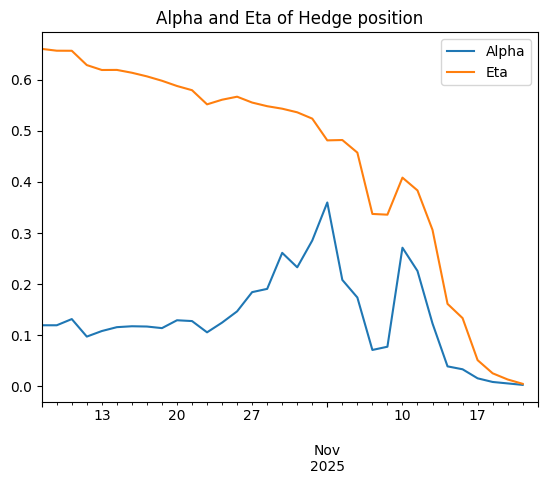

In [60]:
Delta_gamma_df[['Alpha', 'Eta']].plot(title = 'Alpha and Eta of Hedge position') 

In [61]:
delta_vega_df = Delta_gamma_df.copy()

In [62]:
delta_vega_df.head()

,Underlying,C195,T,Date,IV_195C,Delta_195C,Vega_195C,Price_Hedge,T_hedge,IV_Hedge,...,Alpha,Eta,Value_OP,Value_Replicating,Total_Portfolio,Hedging_Error_DV,dOP_daily,dRE_daily,dnl,CumSumDnl
2025-10-07,182.17,12.3,0.123288,2025-10-07,0.669656,0.440105,0.252299,17.82,0.276712,0.580692,...,0.118760,0.660324,1230.0,-1198.332462,31.667538,-2428.332462,NaN,NaN,NaN,NaN
2025-10-08,183.56,11.85,0.120548,2025-10-08,0.635063,0.443596,0.251709,18.18,0.273973,0.575361,...,0.118740,0.656743,1185.0,-1215.755098,-30.755098,-2400.755098,-45.0,-17.422636,-62.422636,-62.422636
2025-10-09,185.47,13.07,0.117808,2025-10-09,0.656761,0.464758,0.252972,19.18,0.271233,0.579569,...,0.130889,0.656622,1307.0,-1283.676789,23.323211,-2590.676789,122.0,-67.921691,54.078309,-8.344326
2025-10-10,175.44,9.3,0.115068,2025-10-10,0.683052,0.374377,0.225549,15.24,0.268493,0.604906,...,0.096547,0.628578,930.0,-974.891071,-44.891071,-1904.891071,-377.0,308.785718,-68.214282,-76.558609
2025-10-13,177.21,9.45,0.106849,2025-10-13,0.685949,0.383887,0.221233,15.05,0.260274,0.587499,...,0.107462,0.618941,945.0,-950.548803,-5.548803,-1895.548803,15.0,24.342268,39.342268,-37.216341


In [68]:
N_calls = 1 
multiplier = 100 


Delta_gamma_df['Value_OP'] = np.nan
Delta_gamma_df['Value_Replicating'] = np.nan 
Delta_gamma_df['Total_Portfolio'] = np.nan
Delta_gamma_df['Short_StockPos'] = np.nan
Delta_gamma_df['Short_optionPos'] = np.nan

for date, row in Delta_gamma_df.iterrows(): 
    alpha = row['Alpha']
    eta = row['Eta']
    call_price = row['C195']
    hedge_price = row['Price_Hedge']
    S = row['Underlying']

    trade_stock = -alpha*S*multiplier
    trade_option = -eta*N_calls*hedge_price*multiplier

    valueOP = N_calls*multiplier*call_price 
    valueRE = trade_stock + trade_option
    totalP = valueOP + valueRE
    
    Delta_gamma_df.at[date, 'Value_OP'] = valueOP
    Delta_gamma_df.at[date, 'Value_Replicating'] = valueRE
    Delta_gamma_df.at[date, 'Total_Portfolio'] = totalP
    Delta_gamma_df.at[date, 'Short_StockPos'] = alpha*multiplier 
    Delta_gamma_df.at[date, 'Short_optionPos'] = eta*N_calls*multiplier


In [70]:
Delta_gamma_df.head()

,Underlying,C195,T,Date,IV_195C,Delta_195C,Vega_195C,Price_Hedge,T_hedge,IV_Hedge,...,Value_OP,Value_Replicating,Total_Portfolio,Hedging_Error_DV,dOP_daily,dRE_daily,dnl,CumSumDnl,Short_StockPos,Short_optionPos
2025-10-07,182.17,12.3,0.123288,2025-10-07,0.669656,0.440105,0.252299,17.82,0.276712,0.580692,...,1230.0,-3340.156649,-2110.156649,-2428.332462,NaN,NaN,NaN,NaN,11.876043,66.032428
2025-10-08,183.56,11.85,0.120548,2025-10-08,0.635063,0.443596,0.251709,18.18,0.273973,0.575361,...,1185.0,-3373.552175,-2188.552175,-2400.755098,-45.0,-17.422636,-62.422636,-62.422636,11.874009,65.674322
2025-10-09,185.47,13.07,0.117808,2025-10-09,0.656761,0.464758,0.252972,19.18,0.271233,0.579569,...,1307.0,-3686.990018,-2379.990018,-2590.676789,122.0,-67.921691,54.078309,-8.344326,13.088851,65.662195
2025-10-10,175.44,9.3,0.115068,2025-10-10,0.683052,0.374377,0.225549,15.24,0.268493,0.604906,...,930.0,-2651.772743,-1721.772743,-1904.891071,-377.0,308.785718,-68.214282,-76.558609,9.654696,62.857800
2025-10-13,177.21,9.45,0.106849,2025-10-13,0.685949,0.383887,0.221233,15.05,0.260274,0.587499,...,945.0,-2835.836431,-1890.836431,-1895.548803,15.0,24.342268,39.342268,-37.216341,10.746182,61.894053


<Axes: title={'center': 'Stock and Option short position'}>

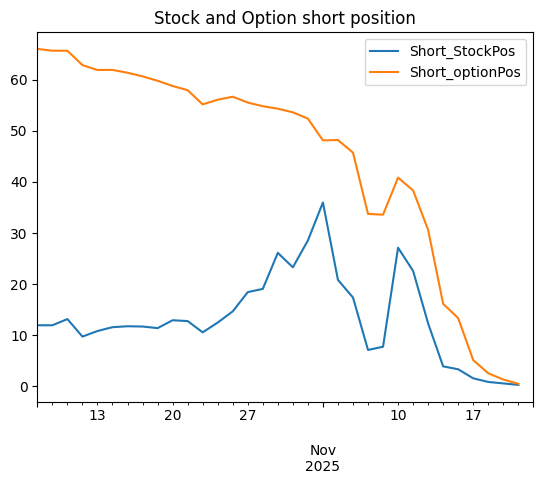

In [71]:
Delta_gamma_df[['Short_StockPos', 'Short_optionPos']].plot(title = 'Stock and Option short position')

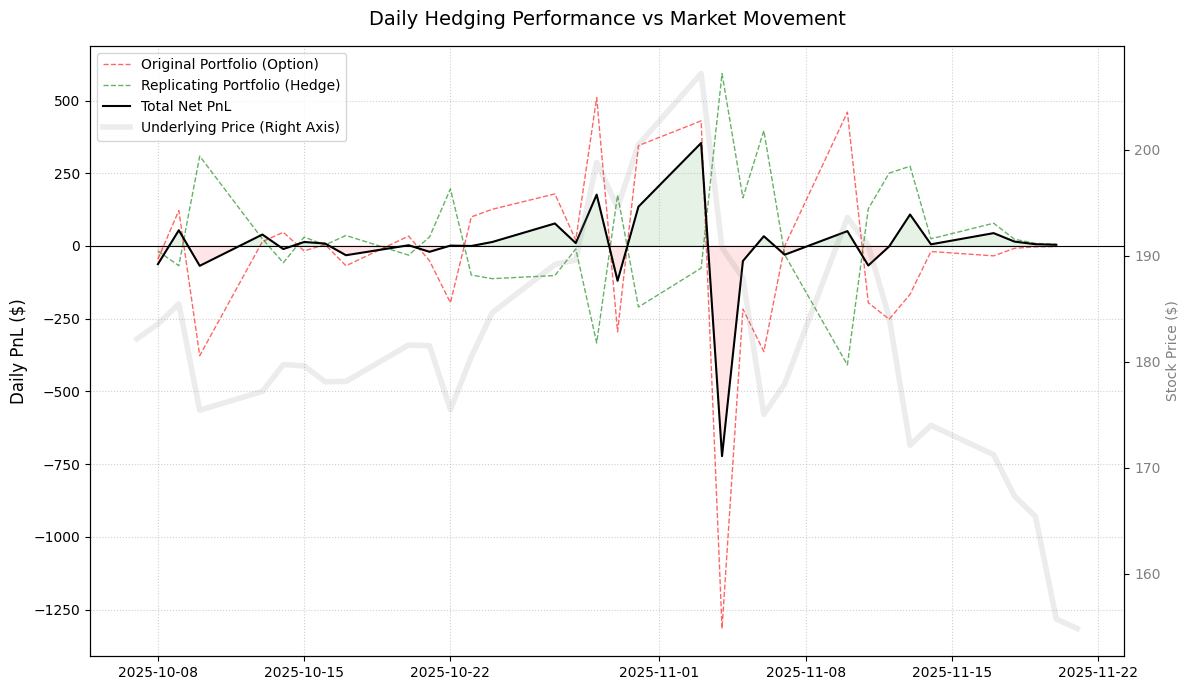

In [74]:
# 1. The Background Layer (Stock Price on Secondary Axis)
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 7))
ax2 = ax1.twinx()  # Create a twin axis sharing the x-axis
ax2.plot(Delta_gamma_df.index, Delta_gamma_df['Underlying'], 
         color='gray', 
         alpha=0.15,       # Very faint
         linewidth=4,      # Thick but faint looks modern
         linestyle='-',
         label='Underlying Price (Right Axis)')
ax2.set_ylabel('Stock Price ($)', color='gray', fontsize=10)
ax2.tick_params(axis='y', labelcolor='gray')
ax2.grid(False) # Turn off grid for the secondary axis to avoid clutter

# 2. The Components (OP and RE)
# We make these thinner and slightly transparent so they don't dominate
ax1.plot(Delta_gamma_df.index, Delta_gamma_df['dOP_daily'], label='Original Portfolio (Option)', 
         color='red', alpha=0.6, linestyle='--', linewidth=1)
ax1.plot(Delta_gamma_df.index, Delta_gamma_df['dRE_daily'], label='Replicating Portfolio (Hedge)', 
         color='green', alpha=0.6, linestyle='--', linewidth=1)

# 3. The "Star" (Total PnL)
ax1.plot(Delta_gamma_df.index, Delta_gamma_df['dnl'], label='Total Net PnL', 
         color='black', linewidth=1.5)

# 4. The "Excellence" Factor (Conditional Shading)
# Fill green where PnL > 0, Red where PnL < 0
ax1.fill_between(Delta_gamma_df.index, Delta_gamma_df['dnl'], 0, 
                 where=(Delta_gamma_df['dnl'] >= 0), 
                 interpolate=True, color='green', alpha=0.1)
ax1.fill_between(Delta_gamma_df.index, Delta_gamma_df['dnl'], 0, 
                 where=(Delta_gamma_df['dnl'] <= 0), 
                 interpolate=True, color='red', alpha=0.1)

# 5. Formatting
ax1.set_title('Daily Hedging Performance vs Market Movement', fontsize=14, pad=15)
ax1.set_ylabel('Daily PnL ($)', fontsize=12)
ax1.axhline(0, color='black', linewidth=0.8) # Strong zero line
ax1.grid(True, linestyle=':', alpha=0.6)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()

In [75]:
Delta_gamma_df

,Underlying,C195,T,Date,IV_195C,Delta_195C,Vega_195C,Price_Hedge,T_hedge,IV_Hedge,...,Value_OP,Value_Replicating,Total_Portfolio,Hedging_Error_DV,dOP_daily,dRE_daily,dnl,CumSumDnl,Short_StockPos,Short_optionPos
2025-10-07,182.17,12.3,0.123288,2025-10-07,0.669656,0.440105,0.252299,17.82,0.276712,0.580692,...,1230.0,-3340.156649,-2110.156649,-2428.332462,NaN,NaN,NaN,NaN,11.876043,66.032428
2025-10-08,183.56,11.85,0.120548,2025-10-08,0.635063,0.443596,0.251709,18.18,0.273973,0.575361,...,1185.0,-3373.552175,-2188.552175,-2400.755098,-45.0,-17.422636,-62.422636,-62.422636,11.874009,65.674322
2025-10-09,185.47,13.07,0.117808,2025-10-09,0.656761,0.464758,0.252972,19.18,0.271233,0.579569,...,1307.0,-3686.990018,-2379.990018,-2590.676789,122.0,-67.921691,54.078309,-8.344326,13.088851,65.662195
2025-10-10,175.44,9.3,0.115068,2025-10-10,0.683052,0.374377,0.225549,15.24,0.268493,0.604906,...,930.0,-2651.772743,-1721.772743,-1904.891071,-377.0,308.785718,-68.214282,-76.558609,9.654696,62.857800
2025-10-13,177.21,9.45,0.106849,2025-10-13,0.685949,0.383887,0.221233,15.05,0.260274,0.587499,...,945.0,-2835.836431,-1890.836431,-1895.548803,15.0,24.342268,39.342268,-37.216341,10.746182,61.894053
2025-10-14,179.74,9.92,0.104110,2025-10-14,0.671556,0.401945,0.224342,15.95,0.257534,0.583822,...,992.0,-3054.998420,-2062.998420,-2000.155598,47.0,-57.606795,-10.606795,-47.823136,11.502826,61.910998
2025-10-15,179.62,9.75,0.101370,2025-10-15,0.675367,0.399164,0.220822,15.59,0.254795,0.578703,...,975.0,-3054.708220,-2079.708220,-1952.510696,-17.0,30.644902,13.644902,-34.178234,11.681212,61.355286
2025-10-16,178.12,9.8,0.098630,2025-10-16,0.714732,0.392279,0.214980,15.72,0.252055,0.604964,...,980.0,-3024.367379,-2044.367379,-1954.032188,5.0,3.478508,8.478508,-25.699726,11.627249,60.643876
2025-10-17,178.15,9.12,0.095890,2025-10-17,0.692454,0.383544,0.210637,15.35,0.249315,0.597599,...,912.0,-2933.557618,-2021.557618,-1849.846318,-68.0,36.185870,-31.814130,-57.513856,11.315577,59.784210
2025-10-20,181.59,9.46,0.087671,2025-10-20,0.675579,0.405764,0.208489,16.1,0.241096,0.584416,...,946.0,-3280.645028,-2334.645028,-1915.371618,34.0,-31.525300,2.474700,-55.039156,12.856543,58.759343


KeyError: "['CumSumOP', 'CumSumRE'] not in index"

<Axes: title={'center': 'Cummulative gains/losses of all three portfolios'}>

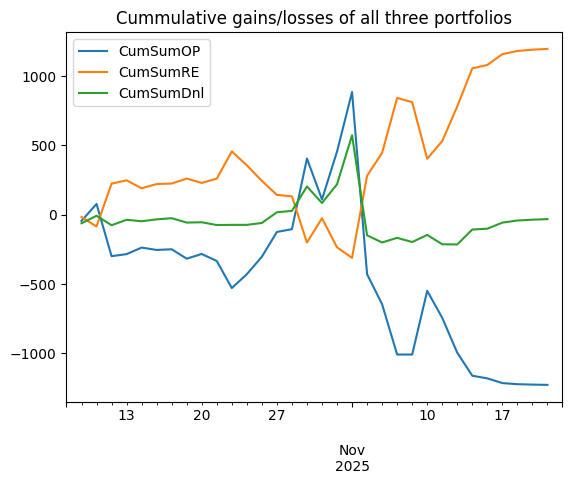

In [77]:
Delta_gamma_df['CumSumOP'] = Delta_gamma_df['dOP_daily'].cumsum()
Delta_gamma_df['CumSumRE'] = Delta_gamma_df['dRE_daily'].cumsum()

Delta_gamma_df[['CumSumOP','CumSumRE','CumSumDnl']].plot(title ='Cummulative gains/losses of all three portfolios')


In [78]:
Delta_gamma_df.tail()

,Underlying,C195,T,Date,IV_195C,Delta_195C,Vega_195C,Price_Hedge,T_hedge,IV_Hedge,...,Total_Portfolio,Hedging_Error_DV,dOP_daily,dRE_daily,dnl,CumSumDnl,Short_StockPos,Short_optionPos,CumSumOP,CumSumRE
2025-11-17,171.25,0.14,0.010959,2025-11-17,0.652704,0.031435,0.012679,7.4,0.164384,0.551218,...,-276.625196,-53.843713,-34.0,78.153629,44.153629,-57.511251,1.479210,5.041968,-1216.0,1158.488749
2025-11-18,167.33,0.06,0.008219,2025-11-18,0.763461,0.014945,0.005727,6.3,0.161644,0.561326,...,-137.614706,-22.802904,-8.0,23.040809,15.040809,-42.470442,0.765510,2.463806,-1224.0,1181.529558
2025-11-19,165.42,0.03,0.005479,2025-11-19,0.912810,0.008250,0.002758,5.59,0.158904,0.559029,...,-83.475878,-10.801848,-3.0,9.001056,6.001056,-36.469386,0.480406,1.253517,-1227.0,1190.530614
2025-11-20,155.745,0.01,0.002740,2025-11-20,1.523960,0.002746,0.000689,3.62,0.156164,0.580631,...,-30.731567,-2.744627,-2.0,6.057221,4.057221,-32.412165,0.194484,0.398268,-1229.0,1196.587835
2025-11-21,154.85,<NA>,0.000000,2025-11-21,NaN,NaN,NaN,3.49,0.153425,0.588776,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
A2 = Delta_gamma_df['dnl'].dropna()
n = len(A2) 
E2 = (A2**2).sum() / (n - 1)
print("Mean Squared Hedging Error:", E2)

Mean Squared Hedging Error: 24441.634139357302


In [80]:
Delta_gamma_df['CumSumRE'].tail()

2025-11-17    1158.488749
2025-11-18    1181.529558
2025-11-19    1190.530614
2025-11-20    1196.587835
2025-11-21            NaN
Freq: B, Name: CumSumRE, dtype: float64

In [82]:
results_df = pd.concat([price_df, Delta_gamma_df], axis=1, join='inner')

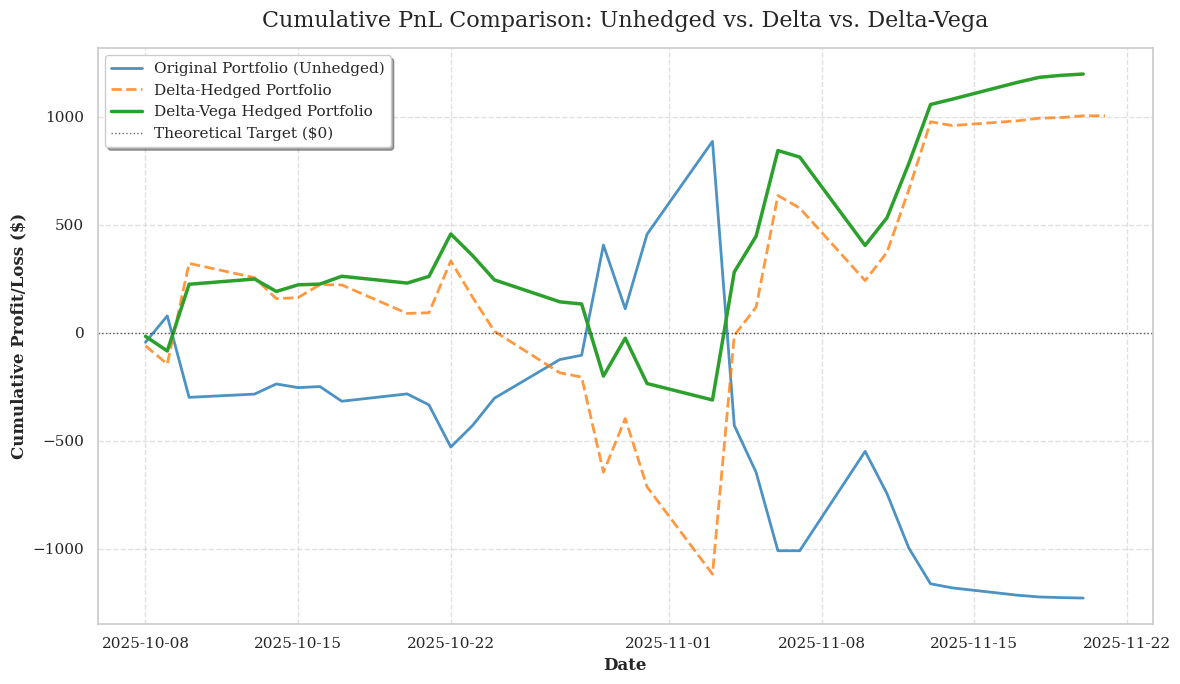

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ------------------------------------------------------------------
# DATA PREPARATION
# ------------------------------------------------------------------
# Ensure your Date column is in datetime format for a clean x-axis
if not isinstance(results_df.index, pd.DatetimeIndex):
    # If Date is a column and not the index:
    # results_df['Date'] = pd.to_datetime(results_df['Date'])
    # results_df.set_index('Date', inplace=True)
    pass

# ------------------------------------------------------------------
# PLOTTING
# ------------------------------------------------------------------
# 1. Set a professional theme
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif" # Serif looks more academic

fig, ax = plt.subplots(figsize=(12, 7))

# 2. Plot the Three Lines
# LINE 1: Original Portfolio (The Risk)
ax.plot(results_df.index, results_df['CumSumOP'], 
        label='Original Portfolio (Unhedged)', 
        color='#1f77b4', # Muted Blue
        linewidth=2, 
        alpha=0.8)

# LINE 2: Delta Hedge Only (The First Fix)
# Note: Ensure this is your Delta-Only column
ax.plot(results_df.index, results_df['CumsumRE'], 
        label='Delta-Hedged Portfolio', 
        color='#ff7f0e', # Muted Orange
        linewidth=2, 
        linestyle='--', 
        alpha=0.8)

# LINE 3: Delta-Vega Hedge (The Complete Fix)
# *** IMPORTANT: Replace 'CumSum_DV' with your actual Delta-Vega column name ***
ax.plot(results_df.index, results_df['CumSumRE'], 
        label='Delta-Vega Hedged Portfolio', 
        color='#2ca02c', # Muted Green
        linewidth=2.5,   # Slightly thicker to highlight it as the "winner"
        linestyle='-')

# 3. Add the "Perfect Hedge" Reference Line
ax.axhline(0, color='black', linewidth=1, linestyle=':', alpha=0.6, label='Theoretical Target ($0)')

# 4. Formatting
ax.set_title('Cumulative PnL Comparison: Unhedged vs. Delta vs. Delta-Vega', fontsize=16, pad=15)
ax.set_ylabel('Cumulative Profit/Loss ($)', fontsize=12, fontweight='bold')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')

# Add Grid and Legend
ax.legend(fontsize=11, loc='best', frameon=True, fancybox=True, shadow=True)
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

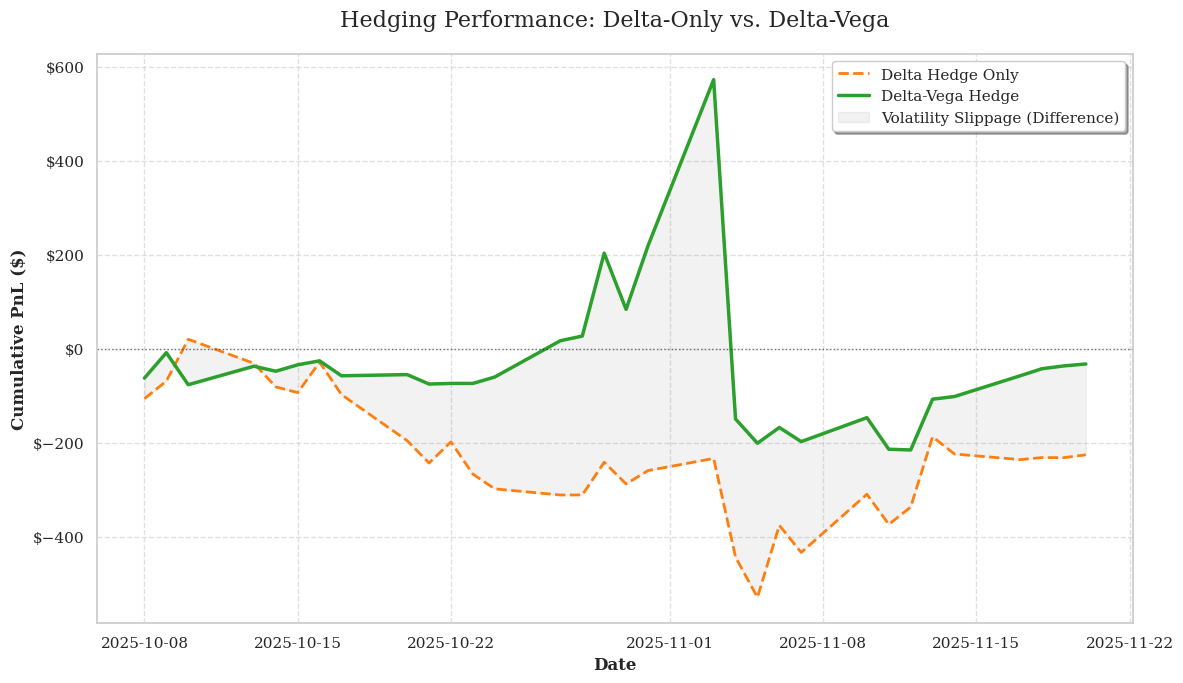

In [86]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import pandas as pd

# ------------------------------------------------------------------
# 1. SETUP & STYLE
# ------------------------------------------------------------------
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif" # Professional academic look

# Create the figure
fig, ax = plt.subplots(figsize=(12, 7))

# ------------------------------------------------------------------
# 2. PLOT THE DATA
# ------------------------------------------------------------------
# Line 1: Delta Hedge (The Baseline)
# We use Orange to signify it is 'good' but not 'best'
ax.plot(results_df.index, results_df['CumsumA'], 
        label='Delta Hedge Only', 
        color='#ff7f0e', # Muted Orange
        linewidth=2, 
        linestyle='--')

# Line 2: Delta-Vega Hedge (The Improved Strategy)
# We use Green to signify 'best' / 'stable'
ax.plot(results_df.index, results_df['CumSumDnl'], 
        label='Delta-Vega Hedge', 
        color='#2ca02c', # Muted Green
        linewidth=2.5)

# ------------------------------------------------------------------
# 3. VISUALIZE THE DIFFERENCE (The "Gap")
# ------------------------------------------------------------------
# This fills the space between the two lines to highlight the divergence
ax.fill_between(results_df.index, 
                results_df['CumsumA'], 
                results_df['CumSumDnl'], 
                color='gray', 
                alpha=0.1, 
                label='Volatility Slippage (Difference)')

# Add a horizontal line at 0 (The Theoretical Goal)
ax.axhline(0, color='black', linewidth=1, linestyle=':', alpha=0.5)

# ------------------------------------------------------------------
# 4. FORMATTING
# ------------------------------------------------------------------
ax.set_title('Hedging Performance: Delta-Only vs. Delta-Vega', fontsize=16, pad=20)
ax.set_ylabel('Cumulative PnL ($)', fontsize=12, fontweight='bold')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')

# Format Y-axis as currency
formatter = mticker.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(formatter)

# Legend
ax.legend(fontsize=11, loc='best', frameon=True, fancybox=True, shadow=True)

# Grid
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [88]:
results_df[['CumsumA', 'CumSumDnl']]

,CumsumA,CumSumDnl
2025-10-07,NaN,NaN
2025-10-08,-106.174644,-62.422636
2025-10-09,-68.901443,-8.344326
2025-10-10,20.250475,-76.558609
2025-10-13,-31.014243,-37.216341
2025-10-14,-81.137774,-47.823136
2025-10-15,-93.314431,-34.178234
2025-10-16,-28.439885,-25.699726
2025-10-17,-97.616721,-57.513856
2025-10-20,-195.555750,-55.039156


In [93]:
Delta_gamma_df.head()
    
    

,Underlying,C195,T,Date,IV_195C,Delta_195C,Vega_195C,Price_Hedge,T_hedge,IV_Hedge,...,Total_Portfolio,Hedging_Error_DV,dOP_daily,dRE_daily,dnl,CumSumDnl,Short_StockPos,Short_optionPos,CumSumOP,CumSumRE
2025-10-07,182.17,12.3,0.123288,2025-10-07,0.669656,0.440105,0.252299,17.82,0.276712,0.580692,...,-2110.156649,-2428.332462,NaN,NaN,NaN,NaN,11.876043,66.032428,NaN,NaN
2025-10-08,183.56,11.85,0.120548,2025-10-08,0.635063,0.443596,0.251709,18.18,0.273973,0.575361,...,-2188.552175,-2400.755098,-45.0,-17.422636,-62.422636,-62.422636,11.874009,65.674322,-45.0,-17.422636
2025-10-09,185.47,13.07,0.117808,2025-10-09,0.656761,0.464758,0.252972,19.18,0.271233,0.579569,...,-2379.990018,-2590.676789,122.0,-67.921691,54.078309,-8.344326,13.088851,65.662195,77.0,-85.344326
2025-10-10,175.44,9.3,0.115068,2025-10-10,0.683052,0.374377,0.225549,15.24,0.268493,0.604906,...,-1721.772743,-1904.891071,-377.0,308.785718,-68.214282,-76.558609,9.654696,62.857800,-300.0,223.441391
2025-10-13,177.21,9.45,0.106849,2025-10-13,0.685949,0.383887,0.221233,15.05,0.260274,0.587499,...,-1890.836431,-1895.548803,15.0,24.342268,39.342268,-37.216341,10.746182,61.894053,-285.0,247.783659


In [97]:
Delta_gamma_df['Net_Vega'] = (Delta_gamma_df['Vega_195C'] * 100) - (Delta_gamma_df['Eta'] * Delta_gamma_df['Vega_Hedge'] * 100)

# Optional: Inspect the result to see if it is close to zero
Delta_gamma_df['Net_Vega']

2025-10-07    0.000000e+00
2025-10-08    0.000000e+00
2025-10-09    0.000000e+00
2025-10-10    0.000000e+00
2025-10-13   -3.552714e-15
2025-10-14   -3.552714e-15
2025-10-15    0.000000e+00
2025-10-16    0.000000e+00
2025-10-17   -3.552714e-15
2025-10-20    0.000000e+00
2025-10-21    0.000000e+00
2025-10-22    0.000000e+00
2025-10-23    0.000000e+00
2025-10-24    3.552714e-15
2025-10-27   -3.552714e-15
2025-10-28    0.000000e+00
2025-10-29    0.000000e+00
2025-10-30    0.000000e+00
2025-10-31    0.000000e+00
2025-11-03    0.000000e+00
2025-11-04    0.000000e+00
2025-11-05    0.000000e+00
2025-11-06    0.000000e+00
2025-11-07    0.000000e+00
2025-11-10    0.000000e+00
2025-11-11    0.000000e+00
2025-11-12    0.000000e+00
2025-11-13    0.000000e+00
2025-11-14    0.000000e+00
2025-11-17    0.000000e+00
2025-11-18    0.000000e+00
2025-11-19    0.000000e+00
2025-11-20   -1.387779e-17
2025-11-21             NaN
Freq: B, Name: Net_Vega, dtype: float64

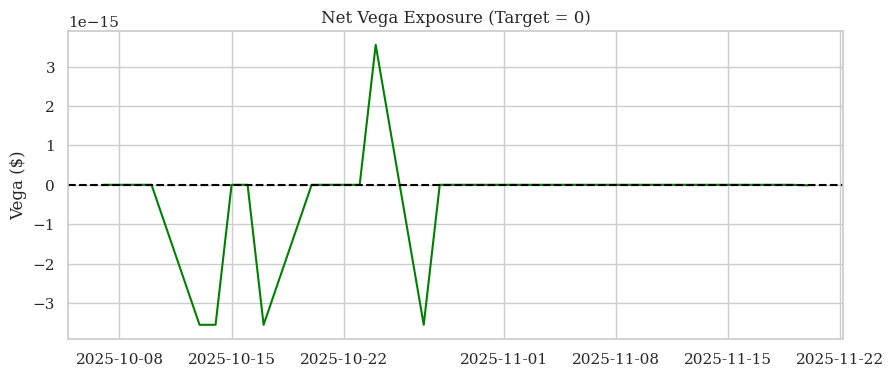

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(Delta_gamma_df.index, Delta_gamma_df['Net_Vega'], label='Net Portfolio Vega', color='green')
plt.axhline(0, color='black', linestyle='--') # The target line
plt.title("Net Vega Exposure (Target = 0)")
plt.ylabel("Vega ($)")
plt.show()

In [23]:
price_df['CumsumOP'] = price_df['dOP'].cumsum()
price_df['CumsumRE'] = price_df['dRE'].cumsum()
price_df['CumsumA'] = price_df['A'].cumsum()
import matplotlib.pyplot as plt

dx = price_df[['CumsumOP', 'CumsumRE', 'CumsumA']].plot(title='Cumulative gains/losses of all three portfolios', figsize=(10,6))

# Add markers for final values
for col in ['CumsumOP', 'CumsumRE', 'CumsumA']:
    last_val = price_df[col].iloc[-1]
    dx.plot(price_df.index[-1], last_val, 'o')  # 'o' makes a circle marker
    dx.text(price_df.index[-1], last_val, f'{last_val:.2f}', fontsize=12, va='bottom')

plt.show()

/var/folders/l0/8w4lhpkj14bfptbgnxd48mtm0000gn/T/ipykernel_15845/3757871273.py:11: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  dx.plot(price_df.index[-1], last_val, 'o')  # 'o' makes a circle marker
